# Multi Agent Architecture
- Combining different Agent Together

### Lets start with combinig Subgraphs together

### Subgraph 1

In [11]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq 
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode

load_dotenv()

True

#### subgraph1 nodes

In [12]:
class ChildState(TypedDict):
    messages: Annotated[list, add_messages]

search_tool  = TavilySearchResults(max_results=2)
tools = [search_tool]

# llm = ChatGroq(model="llama3-8b-8192")   # 8b model  - faster model
llm = ChatGroq(model="llama3-70b-8192")  # 70b model  x8 better but slower

llm_with_tools = llm.bind_tools(tools=tools)

def agent(state:ChildState):
    return {
        "messages":[llm_with_tools.invoke(state["messages"])]
    }

def tools_router(state:ChildState):
    last_message = state["messages"][-1]

    if (hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0) :
        return "tools"
    else:
        return "stop"

tool_node = ToolNode(tools=tools)



#### Subgraph1 Graph

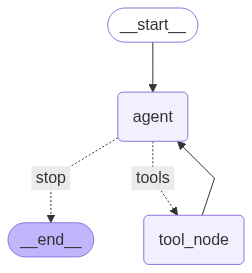

In [14]:
subgraph = StateGraph(ChildState)

subgraph.add_node("agent", agent)
subgraph.add_node("tool_node", tool_node)
subgraph.set_entry_point("agent")

subgraph.add_conditional_edges("agent", tools_router, { "tools":"tool_node", "stop":END})
subgraph.add_edge("tool_node", "agent")

search_app = subgraph.compile()
search_app

In [15]:
result = search_app.invoke({
 "messages":[HumanMessage(content="how is the weather in Abuja today")]   
})

print(result)

KeyError: 'tool_node'